Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import random
import math

# Загружаем данные
df = pd.read_csv('../datasets/famcs_students.csv')

selected_features = ['ss', 'bad_sleep', 'anime', 'literature', 'weekend_study', 'interest']
binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']

# Целевая переменная
y = df['glasses'].apply(lambda x: 1 if x == 'Да' else 0)

# Признаки X
X = df[selected_features].copy()

# Преобразуем категориальные признаки в числовые
# Для простоты будем использовать one-hot encoding для категориальных признаков
categorical_cols = ['sex', 'sport', 'ai', 'social', 'work_experience']
for col in categorical_cols:
    if col in X.columns:
        # Создаем dummy variables
        dummies = pd.get_dummies(X[col], prefix=col, drop_first=True)
        X = pd.concat([X.drop(col, axis=1), dummies], axis=1)

# Также преобразуем бинарные признаки из binary_cols, которые есть в selected_features
for col in binary_cols:
    if col in X.columns and col != 'glasses':
        X[col] = X[col].apply(lambda x: 1 if x == 'Да' else 0)

# Проверим, что все значения числовые
X = X.apply(pd.to_numeric, errors='coerce')

# Заполним пропущенные значения средним
for col in X.columns:
    if X[col].isnull().any():
        X[col].fillna(X[col].mean(), inplace=True)

# Нормализуем признаки (важно для KNN и логистической регрессии)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Разделим данные на train, validation и test (70/15/15)
def train_val_test_split(X, y, train_size=0.7, val_size=0.15):
    n = len(X)
    n_train = int(n * train_size)
    n_val = int(n * val_size)
    
    indices = list(range(n))
    random.shuffle(indices)
    
    train_idx = indices[:n_train]
    val_idx = indices[n_train:n_train + n_val]
    test_idx = indices[n_train + n_val:]
    
    X_train = X.iloc[train_idx].reset_index(drop=True)
    X_val = X.iloc[val_idx].reset_index(drop=True)
    X_test = X.iloc[test_idx].reset_index(drop=True)
    
    y_train = y.iloc[train_idx].reset_index(drop=True)
    y_val = y.iloc[val_idx].reset_index(drop=True)
    y_test = y.iloc[test_idx].reset_index(drop=True)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)

print(f"Размеры выборок: train={len(X_train)}, val={len(X_val)}, test={len(X_test)}")
print(f"Баланс классов в train: {y_train.mean():.3f}")
print(f"Баланс классов в val: {y_val.mean():.3f}")
print(f"Баланс классов в test: {y_test.mean():.3f}")

Размеры выборок: train=88, val=19, test=20
Баланс классов в train: 0.568
Баланс классов в val: 0.316
Баланс классов в test: 0.600


## 0. Тривиальный классификатор

In [60]:
# Тривиальный классификатор
from sklearn.dummy import DummyClassifier

trivial_clf = DummyClassifier(strategy='most_frequent')
trivial_clf.fit(X_train, y_train)

y_pred_trivial = trivial_clf.predict(X_test)

# Оценка
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix

print("Тривиальный классификатор:")
print("Accuracy:", accuracy_score(y_test, y_pred_trivial))
print("Precision:", precision_score(y_test, y_pred_trivial, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_trivial, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_trivial))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_trivial))

Тривиальный классификатор:
Accuracy: 0.6
Precision: 0.6
Recall: 1.0
ROC-AUC: 0.5
Confusion matrix:
 [[ 0  8]
 [ 0 12]]


## 1. Наивный байесовский классификатор

In [61]:
class GaussianNaiveBayes:
    def __init__(self):
        self.classes_ = None
        self.mean_ = {}
        self.var_ = {}
        self.priors_ = {}
    
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        for c in self.classes_:
            X_c = X[y == c]
            self.mean_[c] = X_c.mean(axis=0)
            self.var_[c] = X_c.var(axis=0) + 1e-9
            self.priors_[c] = X_c.shape[0] / X.shape[0]
    
    def _pdf(self, x, mean, var):
        return (1 / np.sqrt(2 * np.pi * var)) * np.exp(-0.5 * (x - mean) ** 2 / var)
    
    def predict_proba(self, X):
        probas = []
        for c in self.classes_:
            prior = np.log(self.priors_[c])
            likelihood = np.sum(np.log(self._pdf(X, self.mean_[c], self.var_[c])), axis=1)
            posterior = prior + likelihood
            probas.append(posterior)
        probas = np.vstack(probas).T
        return np.exp(probas) / np.exp(probas).sum(axis=1, keepdims=True)
    
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]

# Обучение
gnb = GaussianNaiveBayes()
gnb.fit(X_train.values, y_train.values)

y_pred_nb = gnb.predict(X_test.values)

# Оценка
print("\nНаивный байесовский классификатор:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_nb, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_nb))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_nb))


Наивный байесовский классификатор:
Accuracy: 0.45
Precision: 0.5384615384615384
Recall: 0.5833333333333334
ROC-AUC: 0.4166666666666667
Confusion matrix:
 [[2 6]
 [5 7]]


## 2. Метод k-ближайших соседей

In [62]:
class KNN:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self, X):
        predictions = []
        for x in X:
            distances = np.sqrt(((self.X_train - x) ** 2).sum(axis=1))
            nearest_indices = np.argsort(distances)[:self.k]
            nearest_labels = self.y_train[nearest_indices]
            pred = np.bincount(nearest_labels).argmax()
            predictions.append(pred)
        return np.array(predictions)

# Масштабирование признаков
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Подбор k
best_k = 1
best_acc = 0
for k in range(1, 8):
    knn = KNN(k=k)
    knn.fit(X_train_scaled, y_train.values)
    y_pred_val = knn.predict(X_val_scaled)
    acc = accuracy_score(y_val, y_pred_val)
    if acc > best_acc:
        best_acc = acc
        best_k = k

print(f"Лучшее k: {best_k}")

# Обучение с лучшим k
knn_best = KNN(k=best_k)
knn_best.fit(X_train_scaled, y_train.values)
y_pred_knn = knn_best.predict(X_test_scaled)

# Оценка
print(f"\nМетод k-ближайших соседей, k = {best_k}")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Precision:", precision_score(y_test, y_pred_knn, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_knn, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_knn))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_knn))

Лучшее k: 6

Метод k-ближайших соседей, k = 6
Accuracy: 0.35
Precision: 0.4444444444444444
Recall: 0.3333333333333333
ROC-AUC: 0.35416666666666663
Confusion matrix:
 [[3 5]
 [8 4]]


## 3. Логистическая регрессия

Лучший порог: 0.4300000000


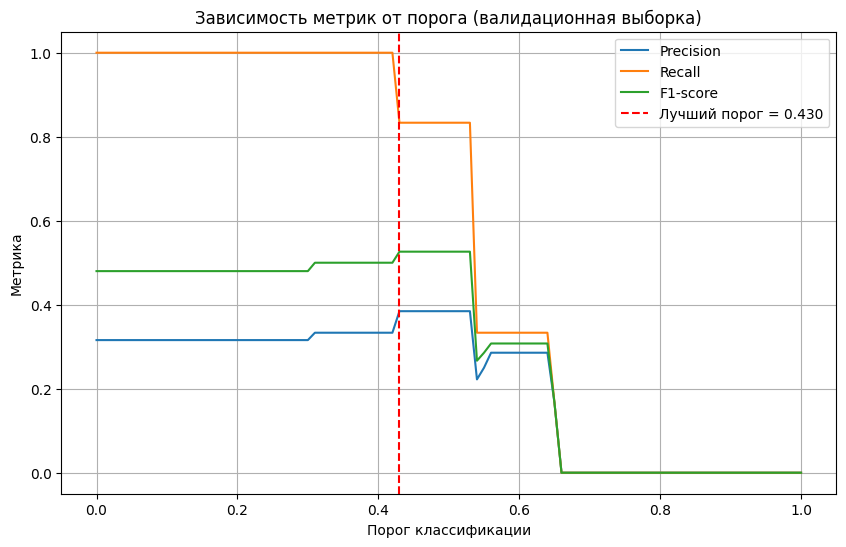


Логистическая регрессия:
Accuracy: 0.45
Precision: 0.5384615384615384
Recall: 0.5833333333333334
ROC-AUC: 0.41666666666666663
Confusion matrix:
 [[2 6]
 [5 7]]


In [63]:
class LogisticRegressionCustom:
    def __init__(self, lr=0.01, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for _ in range(self.n_iters):
            linear = np.dot(X, self.weights) + self.bias
            y_pred = self._sigmoid(linear)
            
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)
            
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
    
    def predict_proba(self, X):
        linear = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear)
    
    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)

# Обучение
lr = LogisticRegressionCustom(lr=0.01, n_iters=3000)
lr.fit(X_train_scaled, y_train.values)

# Подбор порога по валидационной выборке
from sklearn.metrics import precision_score, recall_score, f1_score

val_proba = lr.predict_proba(X_val_scaled)
thresholds = np.linspace(0, 1, 101)
f1_scores = []

for t in thresholds:
    y_pred_val_t = (val_proba >= t).astype(int)
    f1 = f1_score(y_val, y_pred_val_t, zero_division=0)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Лучший порог: {best_threshold:.10f}")

# График precision, recall, F1 от порога
precisions = []
recalls = []
for t in thresholds:
    y_pred_val_t = (val_proba >= t).astype(int)
    precisions.append(precision_score(y_val, y_pred_val_t, zero_division=0))
    recalls.append(recall_score(y_val, y_pred_val_t, zero_division=0))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-score')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Лучший порог = {best_threshold:.3f}')
plt.xlabel('Порог классификации')
plt.ylabel('Метрика')
plt.title('Зависимость метрик от порога (валидационная выборка)')
plt.legend()
plt.grid()
plt.show()

# Прогноз на тесте с лучшим порогом
y_pred_lr = lr.predict(X_test_scaled, threshold=best_threshold)

# Оценка
print("\nЛогистическая регрессия:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_lr, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, lr.predict_proba(X_test_scaled)))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_lr))

## 4. Оценка качества


Сравнение моделей (целевая переменная: glasses):
                 Модель  Accuracy  Precision   Recall  ROC-AUC
            Тривиальный      0.60   0.600000 1.000000 0.500000
          Наивный Байес      0.45   0.538462 0.583333 0.416667
                    KNN      0.35   0.444444 0.333333 0.354167
Логистическая регрессия      0.45   0.538462 0.583333 0.416667


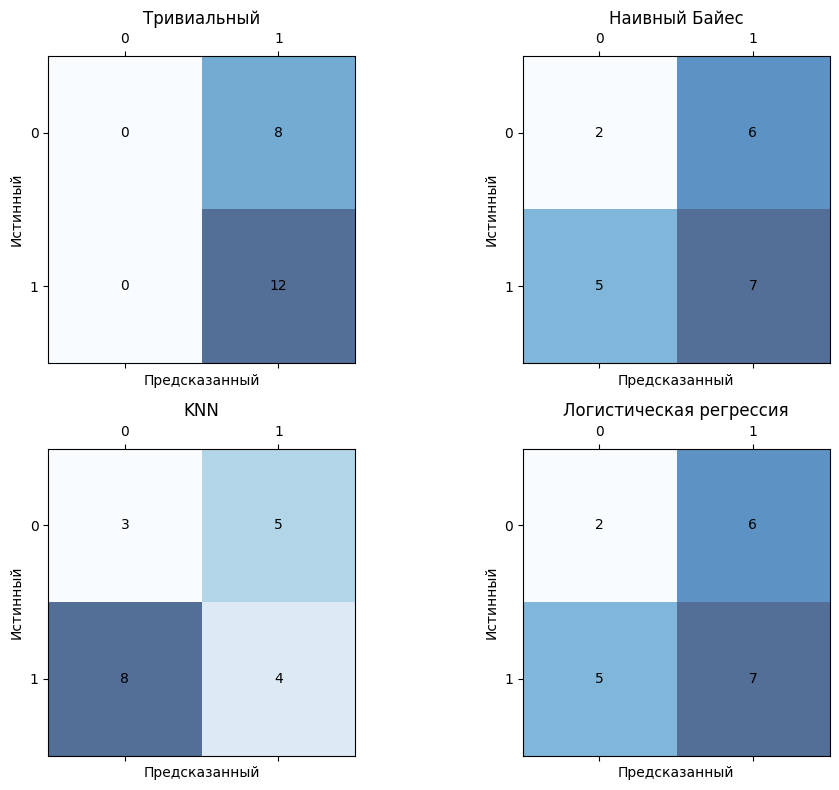

In [64]:
import matplotlib.pyplot as plt

models = {
    "Тривиальный": y_pred_trivial,
    "Наивный Байес": y_pred_nb,
    "KNN": y_pred_knn,
    "Логистическая регрессия": y_pred_lr
}

results = []
for name, preds in models.items():
    results.append({
        "Модель": name,
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds, zero_division=0),
        "Recall": recall_score(y_test, preds, zero_division=0),
        "ROC-AUC": roc_auc_score(y_test, preds)
    })

results_df = pd.DataFrame(results)
print("\nСравнение моделей (целевая переменная: glasses):")
print(results_df.to_string(index=False))

# Матрицы ошибок
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()
for (name, preds), ax in zip(models.items(), axes):
    cm = confusion_matrix(y_test, preds)
    ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.7)
    ax.set_title(name)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i, j]}", ha='center', va='center', color='black')
    ax.set_xlabel('Предсказанный')
    ax.set_ylabel('Истинный')
plt.tight_layout()
plt.show()